# Imports and utility functions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multianndata as md
import vima.data.samples as vds
import vima.data.patchcollection as vdp
import vima.association as va
import vima.training as vt
import vima.vis as vv
import gc, os, cna, torch
import scanpy as sc
torch.set_default_device('mps') # for running on macbook's GPU

patchsize = 40; patchstride = 10

In [49]:
def do_cna(d, pheno=None, ks=[1,2,3,4], Nnull=100000):
    cna.tl.nam(d, force_recompute=True)
    np.random.seed(0)
    if pheno is None:
        d.samplem['case'] = (d.samplem.Status == 'UC').astype('float')
        d.samplem.loc[(d.samplem.TNFnow == 'y') | (d.samplem.TNFprior == 'y'), 'case'] = np.nan
    else:
        d.samplem['case'] = pheno
        
    res = cna.tl.association(d, d.samplem.case, donorids=d.samplem.donor.values, Nnull=Nnull, ks=ks)
    print(f'Ncases={d.samplem.case.sum()}: P = {res.p}, used {res.k} PCs')
    d.obs['ncorr'] = res.ncorrs
    if res.fdrs.fdr.min() <= 0.1:
        print(f'{res.fdrs[res.fdrs.fdr < 0.1].iloc[0].num_detected} at FDR 10%')
        d.obs['ncorr_thresh'] = res.ncorrs * (np.abs(res.ncorrs) > res.fdrs[res.fdrs.fdr < 0.1].iloc[0].threshold)
    else:
        d.obs['ncorr_thresh'] = 0
    d.samplem.loc[~np.isnan(d.samplem.case), 'yhat'] = res.yresid_hat

def test_clusters(df, cols, pheno, donor, Nnull=1000):
    X = df[cols].values.copy()
    pheno = df[pheno].copy()
    donorids = df[donor].copy()
    mask = ~np.isnan(pheno)
    X = X[mask]; pheno = pheno[mask]; donorids = donorids[mask]
    
    X = (X - X.mean(axis=0))/X.std(axis=0)
    y_ = cna.tl._stats.grouplevel_permutation(donorids, pheno, Nnull).astype('float')
    pheno = (pheno - pheno.mean())/pheno.std()
    y_ -= y_.mean(axis=0)
    y_ /= y_.std(axis=0)
    
    ncorrs = X.T.dot(pheno) / len(X)
    nullncorrs = X.T.dot(y_) / len(X)
    pvals = ((np.abs(nullncorrs) >= np.abs(ncorrs)[:,None]).sum(axis=1) + 1)/(Nnull + 1)
    
    maxcorr = max(np.abs(ncorrs).max(), 0.001)
    fdr_thresholds = np.arange(maxcorr/4, maxcorr, maxcorr/400)
    fdr_vals = cna.tl._stats.empirical_fdrs(ncorrs, nullncorrs, fdr_thresholds)

    fdrs = pd.DataFrame({
        'threshold':fdr_thresholds,
        'fdr':fdr_vals,
        'num_detected': [(np.abs(ncorrs)>t).sum() for t in fdr_thresholds]})
    return fdrs, ncorrs, pvals

# Load dataset and make patches

In [5]:
# read in samples
def fname_parser(fname): 
    fname = fname.split("/")[-1].split(".nc")[0]
    if fname[-1].islower():
        donor = fname[:-1]
    else: 
        donor = fname
    return {'sid': fname, 'donor': donor}
repname = 'pca_k=10_harmony'
samples = vds.read_samples(f'../../UC/UC-data/10u/{repname}/*.nc', fname_parser)

100%|███████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 37.79it/s]


In [6]:
# choose which patches to train on
P = vdp.PatchCollection(
    vds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.8),
                        samples, standardize=True)
sid_nums = {sid:sid_num for sid, sid_num in P.meta[['sid','sid_num']].drop_duplicates().values}
print(len(P), 'patches')

# choose which patches to do case/ctrl analysis on
Pdense = vdp.PatchCollection(
    vds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.5),
                        samples, sid_nums=sid_nums, standardize=True)
print(len(Pdense), 'dense patches')

100%|███████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.85it/s]


in pytorch mode
means: [ 0.10415696  0.03282076 -0.01539151 -0.05838594 -0.05422096  0.00433618
  0.00879702 -0.09059121  0.01674924  0.0496942 ]
stds: [2.7761626  1.616246   1.5295948  0.9855275  0.7065326  0.6949702
 0.85679114 0.709474   0.8511923  0.7017485 ]
data augmentation is off
25869 patches


100%|███████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 19.30it/s]


in pytorch mode
means: [ 0.08237332  0.01278704 -0.03403955 -0.06954325 -0.06288863 -0.00149597
  0.01077008 -0.10602087  0.00874049  0.04395648]
stds: [2.911984   1.713643   1.6146119  1.0410779  0.75082374 0.7381439
 0.90176827 0.75134045 0.8896265  0.7413416 ]
data augmentation is off
21359 dense patches


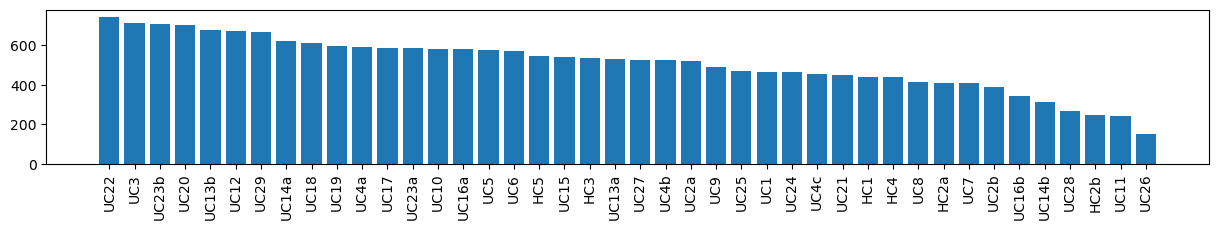

42it [00:01, 21.10it/s]
/Users/yakir/Dropbox/py/tpae/data/samples.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


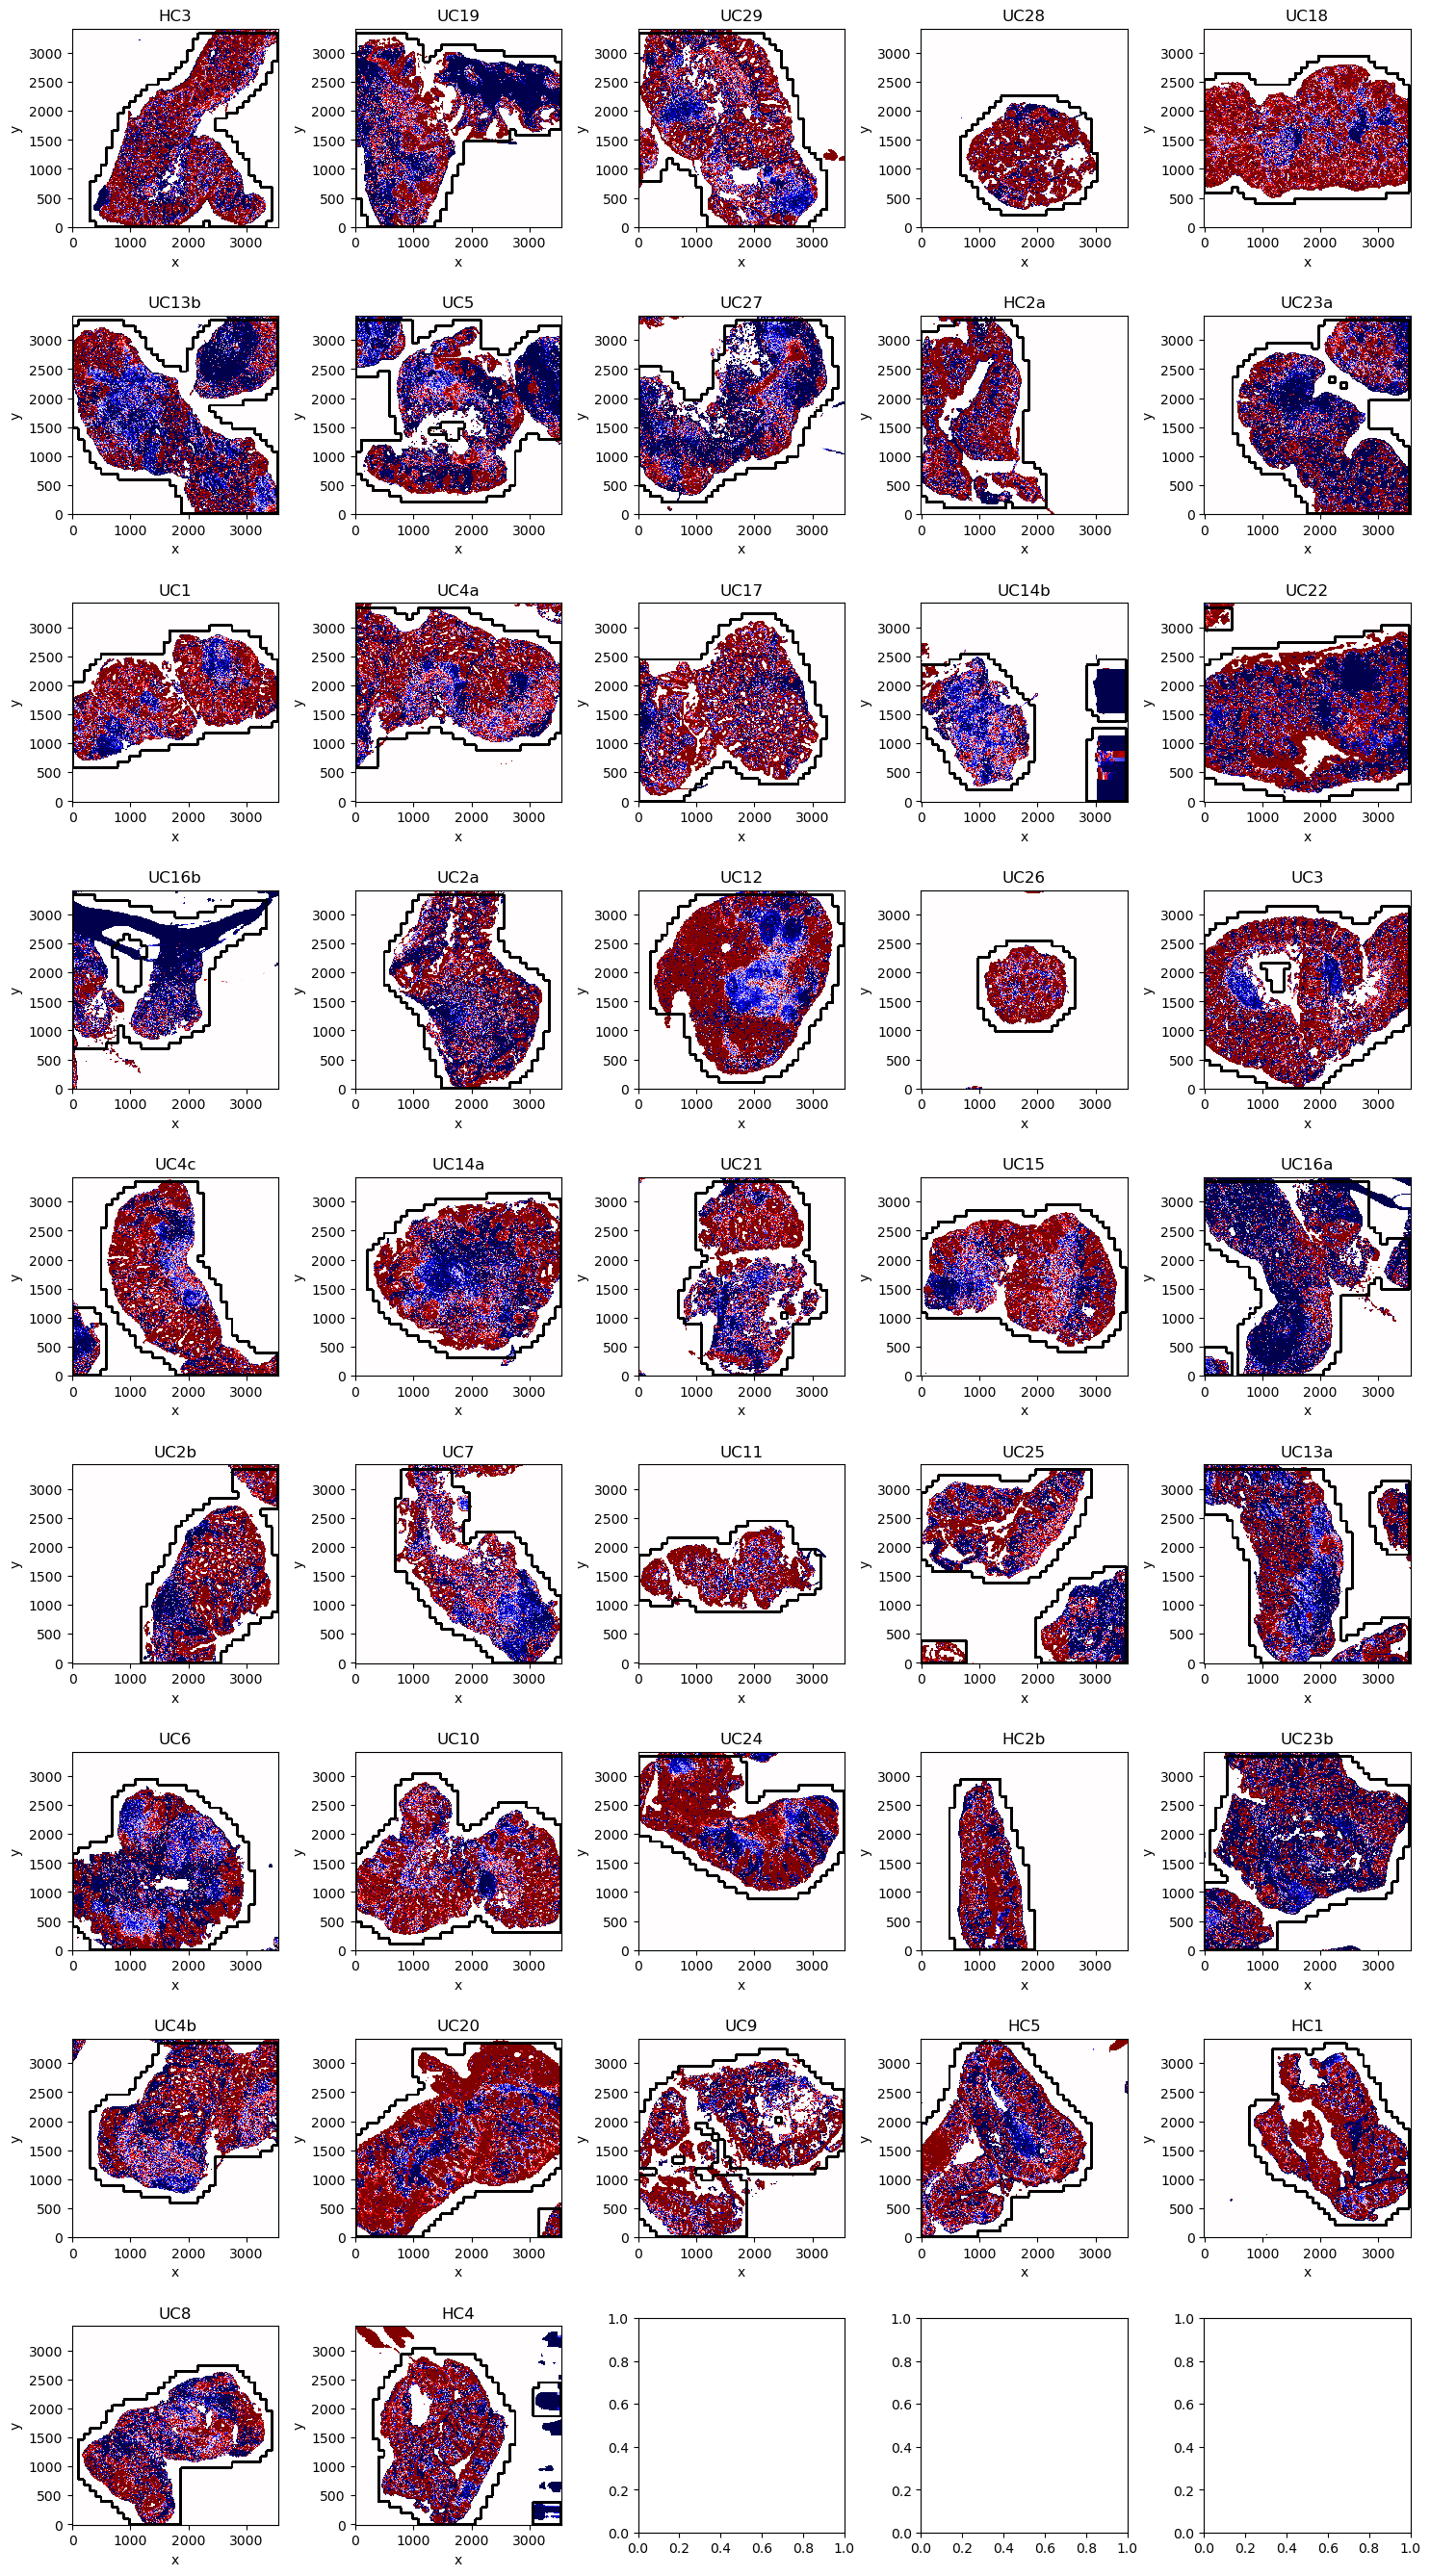

In [5]:
# visualize resulting patches
vds.plot_npatches_per_sample(samples, Pdense.meta)
vds.plot_samples_with_patches(samples.values(), 'hPC1', Pdense.meta, ncols=5, vmin=-2, vmax=2, cmap='seismic')

In [9]:
# read in sample metadata
samplemeta = pd.read_csv('../../UC/UC-data/2024_10_16_UC_Patient_Metadata.csv').rename(columns={'NEW Label':'sid', 'Patient.ID':'donor'}).set_index('sid', drop=True)
samplemeta.donor = samplemeta.donor.astype('str')

# Train VAE

In [24]:
from vima.models.resnet_vae import ResnetVAE
vt.seed(0)
model = ResnetVAE(len(P.meta.sid.unique()), network='light', mode='advanced', ncolors=P.nchannels, nlatent=100)
kl_weight = 1e-5
name = 'default'
os.makedirs(f'./_results', exist_ok=True)

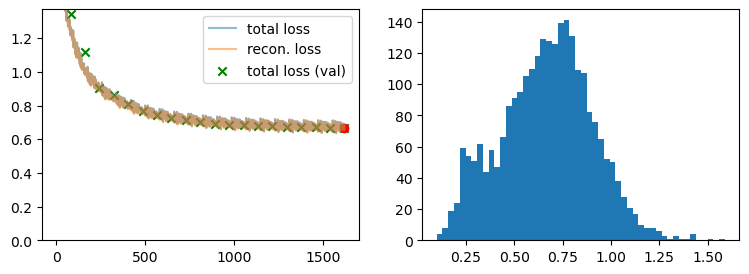

epoch 20. best validation loss = 0.667190670967102
	total time: 38.04861783981323


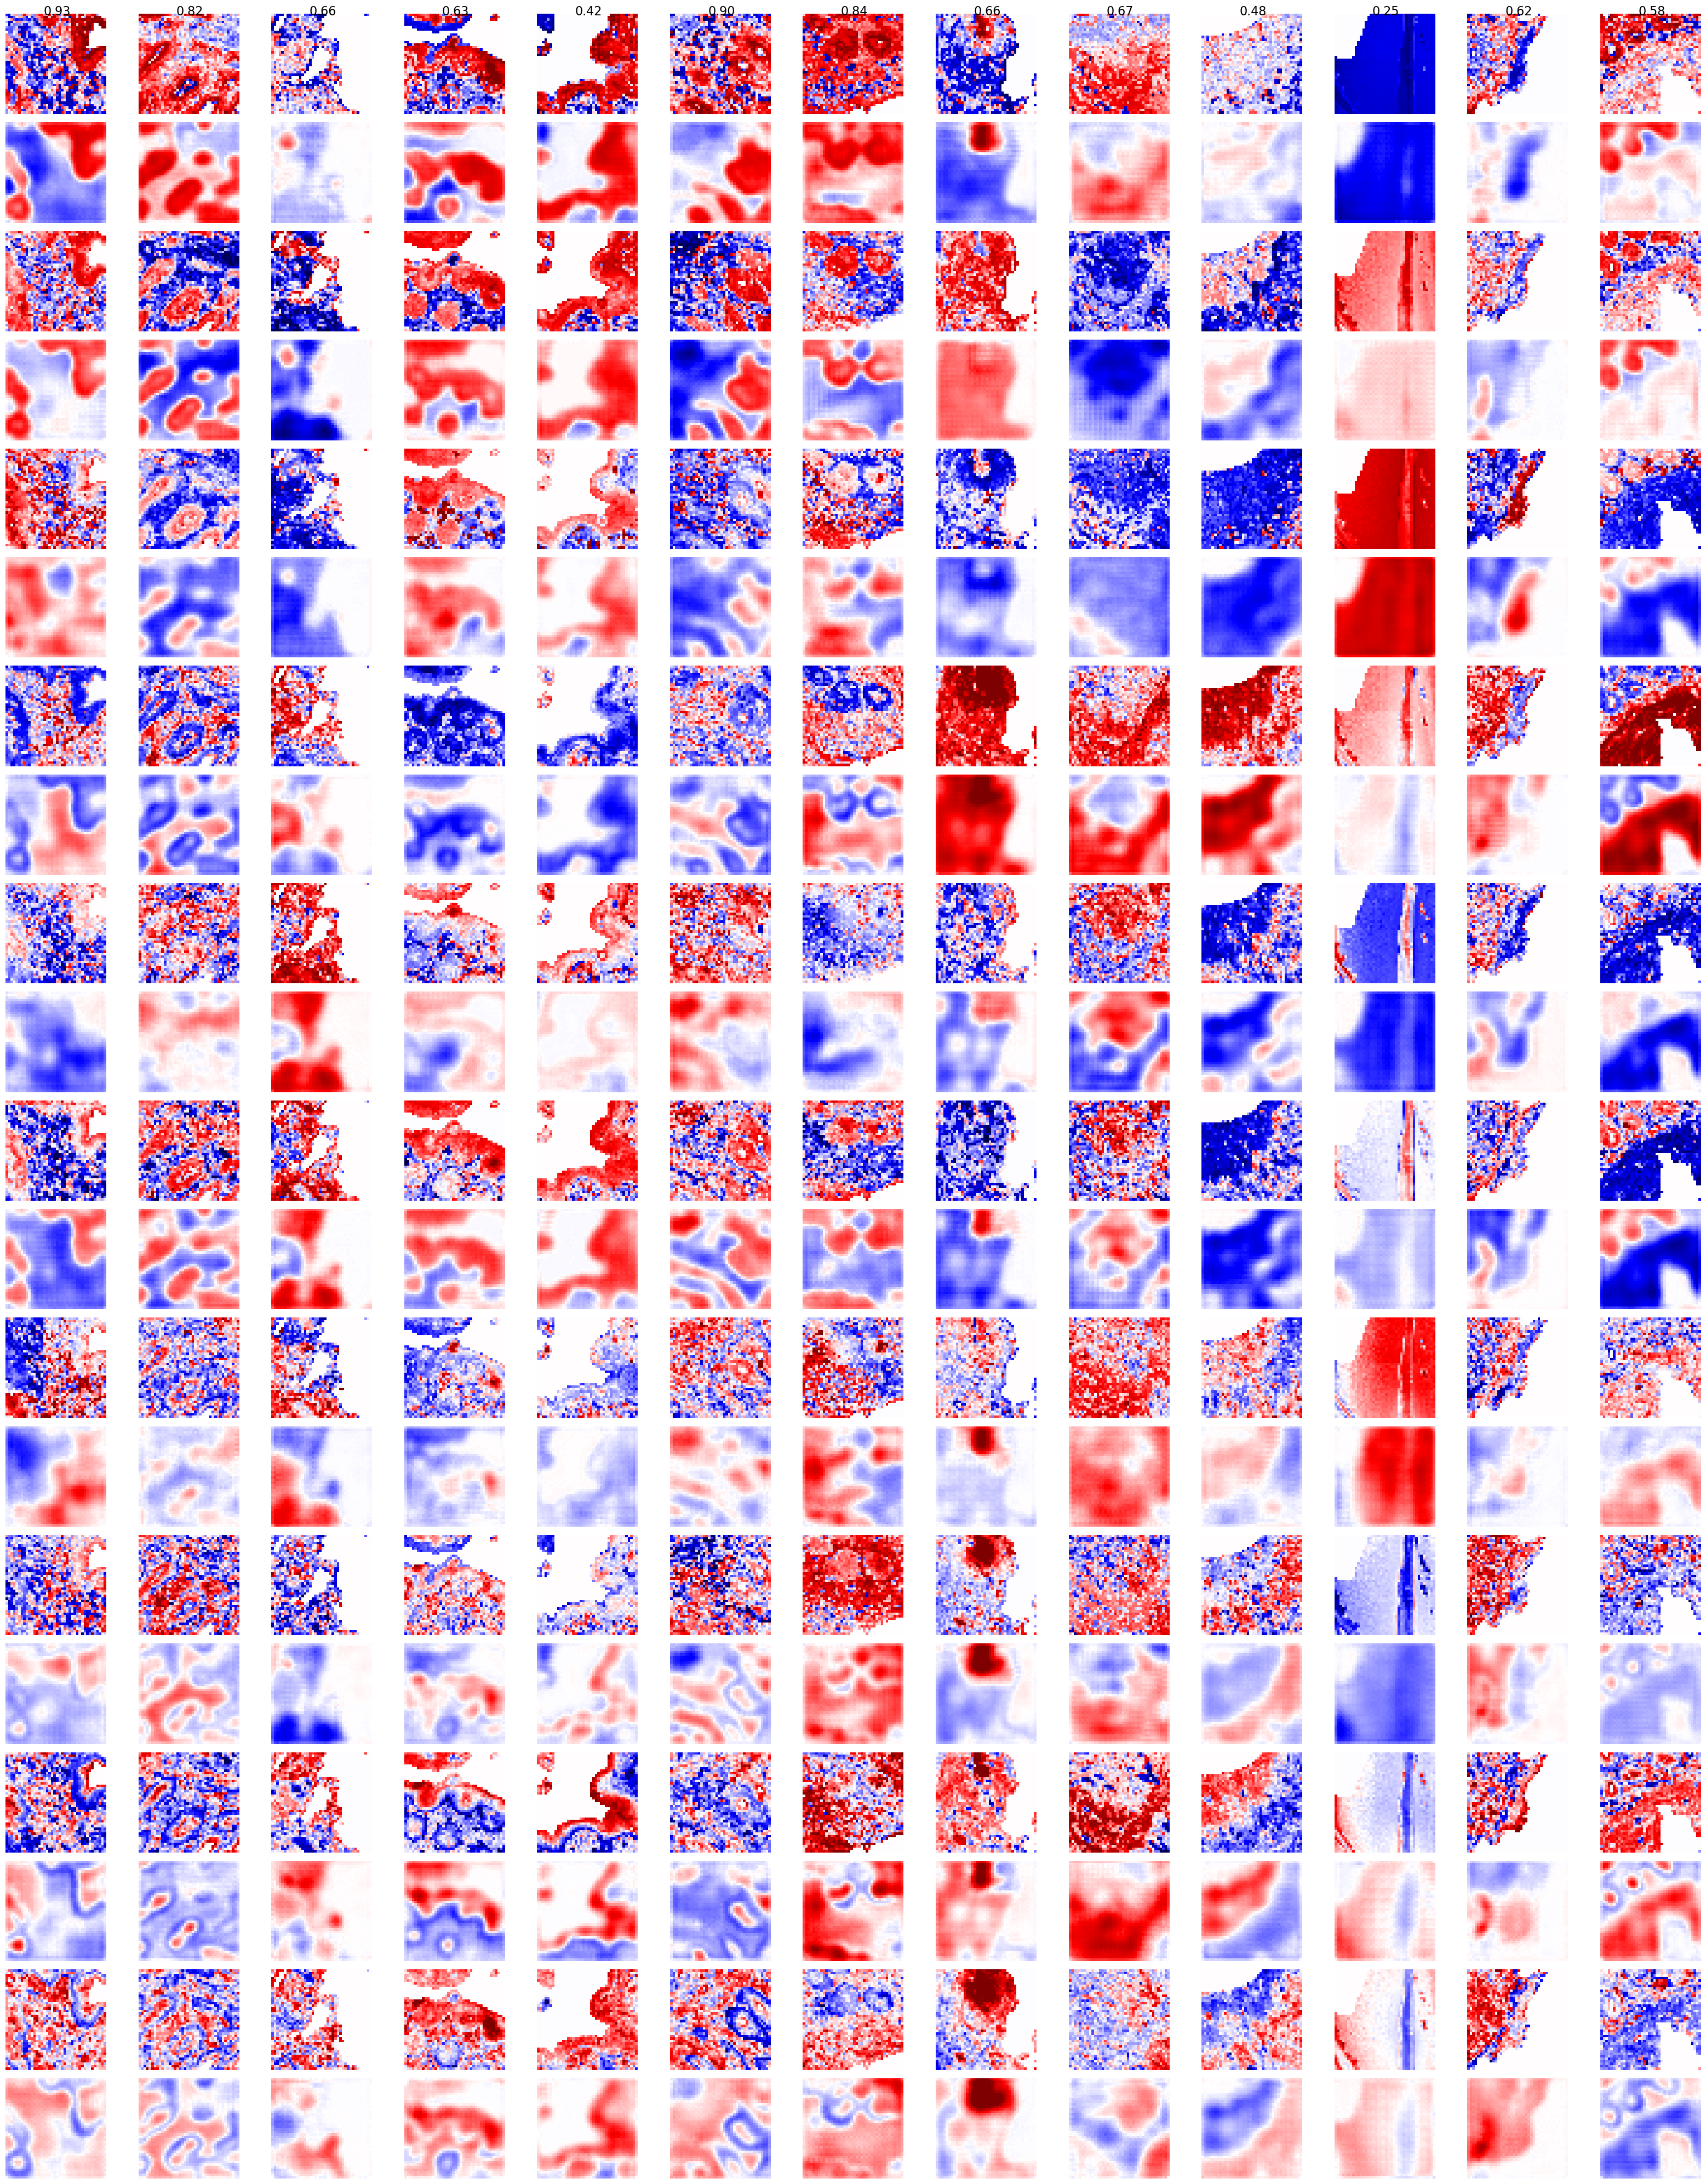

In [8]:
train_dataset, val_dataset = vt.train_test_split(P)
vv.plot_patches_separatechannels(val_dataset[:16][0].permute(0,2,3,1).cpu().numpy())

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
model, losslogs = vt.full_training(model, train_dataset, val_dataset, optimizer, scheduler, batch_size=256, n_epochs=20,
                                kl_weight=kl_weight,
                                per_epoch_logging=vt.detailed_per_epoch_logging,
                                per_epoch_kwargs={'Pmin':P.vmin, 'Pmax':P.vmax})
torch.save(model.state_dict(), f'_results/{name}-vae.pt')

# Create patch representations

## VAE representation

in pytorch mode
data augmentation is off


100%|███████████████████████████████████████████████████████████████| 22/22 [00:07<00:00,  2.82it/s]


running UMAP


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


built MultiAnnData object with sid as the unit of analysis


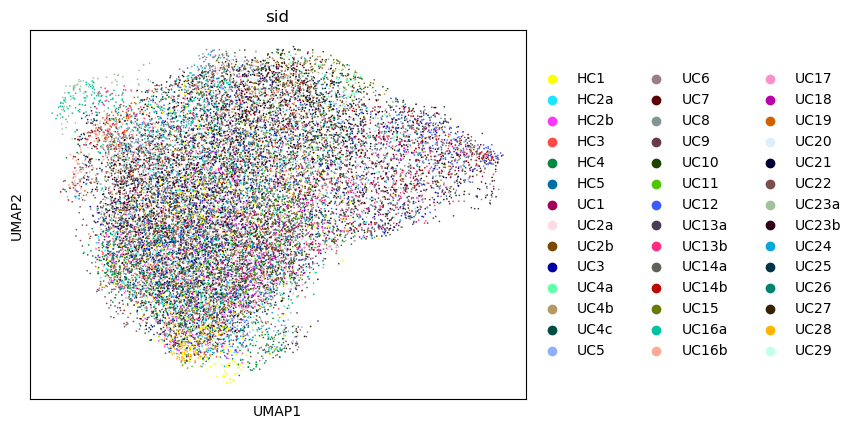

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_51046/451382375.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(Ddense)


In [27]:
# load model
from vima.models.resnet_vae import ResnetVAE
model = ResnetVAE(len(P.meta.sid.unique()), network='light', mode='advanced', ncolors=P.nchannels, nlatent=100)
model.load_state_dict(torch.load(f'_results/{name}-vae.pt'))

# apply model and build umap
Ddense = va.anndata(Pdense.meta,
                    va.apply(model, Pdense, embedding=model.embedding),
                    samplemeta[samplemeta.index.isin(Pdense.meta.sid.unique())],
                    sampleid='sid')
sc.pl.umap(Ddense, color='sid')
sc.tl.leiden(Ddense)

Ddense.write(f'_results/{name}-vae.h5ad')

## Patchwide avg representation

data augmentation is off
in numpy mode


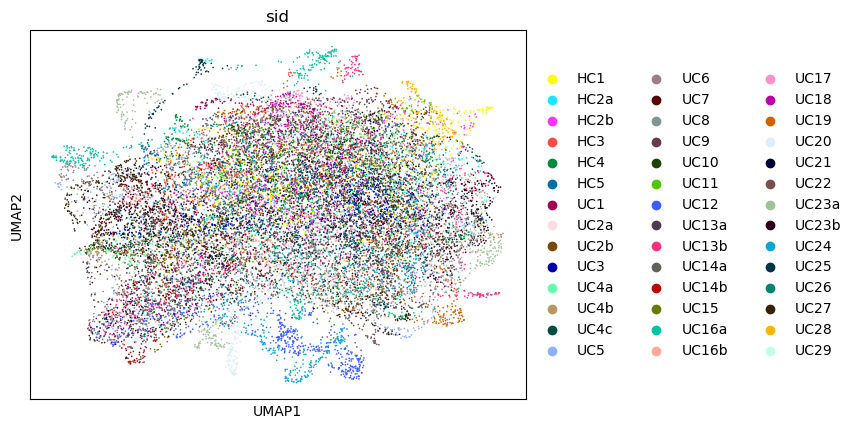

In [22]:
Pdense.numpy_mode()
Ddense_avg = md.MultiAnnData(
    X=Pdense[:][0].mean(axis=(1,2)),
    obs=Ddense.obs)
Ddense_avg.samplem = Ddense.samplem
Ddense_avg.sampleid = 'id'
sc.pp.neighbors(Ddense_avg, use_rep='X')
sc.tl.umap(Ddense_avg)
sc.tl.leiden(d, resolution=1)
Ddense_avg.write(f'_results/patchwideavgs.h5ad')
sc.pl.umap(Ddense_avg, color='sid')

# Case-control analysis

## Patch fingerprints -> cluster

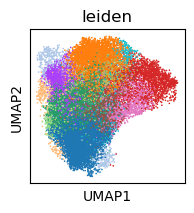

/Users/yakir/Dropbox/py/cna/src/cna/tools/_stats.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Yg = np.array([Y[G==g][0] for g in Gu])


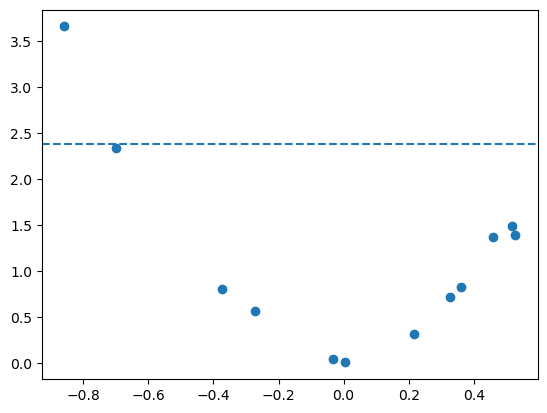

In [55]:
from scipy.stats import ttest_ind
d = cna.read(f'_results/default-vae.h5ad'); d.sampleid = 'sid'
plt.figure(figsize=(2,2)); sc.pl.umap(d, color='leiden', legend_loc=None, ax=plt.gca())
ct = pd.crosstab(d.obs.sid, d.obs.leiden)
ct = ct.div(ct.sum(axis=1), axis=0)
clusts = ct.columns.values
ct['donor'] = d.samplem.donor
ct['case'] = (d.samplem.Status == 'UC').astype('float')
ct.loc[(d.samplem.TNFnow == 'y') | (d.samplem.TNFprior == 'y'), 'case'] = np.nan
    
fdrs, stats, ps = test_clusters(ct, clusts, 'case', 'donor', Nnull=100000)
plt.scatter(stats, -np.log10(ps))
plt.axhline(-np.log10(0.05/len(ps)), ls='--')
plt.show()
pd.DataFrame(data={'p':ps, 'stat':stats}, index=pd.Series(d.obs.leiden.unique(), name='cluster')
            ).to_csv('_results/patchfingerprints_clustertest.csv')

In [57]:
ps[ps <= 0.05/len(ps)], clusts[ps <= 0.05/len(ps)], (d.obs['leiden'] == '11').sum()

(array([0.00022]),
 ['11']
 Categories (12, object): ['0', '1', '2', '3', ..., '8', '9', '10', '11'],
 397)

## patchwide averages -> cluster

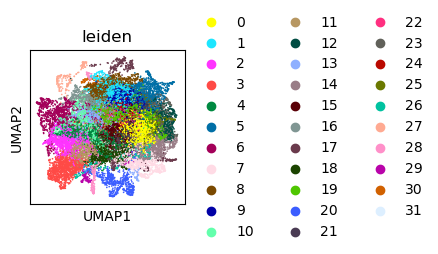

/Users/yakir/Dropbox/py/cna/src/cna/tools/_stats.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Yg = np.array([Y[G==g][0] for g in Gu])


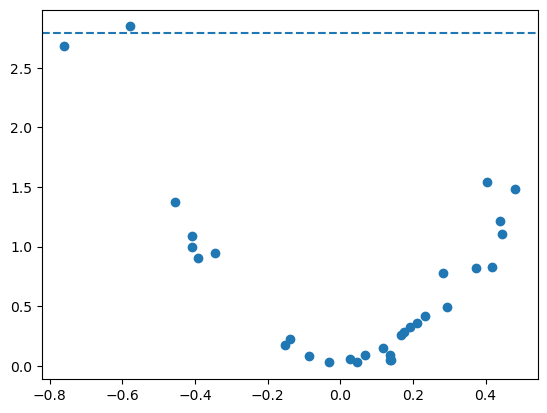

In [59]:
from scipy.stats import ttest_ind
d = cna.read(f'_results/patchwideavgs.h5ad'); d.sampleid = 'sid'
plt.figure(figsize=(2,2)); sc.pl.umap(d, color='leiden', ax=plt.gca())
ct = pd.crosstab(d.obs.sid, d.obs.leiden)
ct = ct.div(ct.sum(axis=1), axis=0)
clusts = ct.columns.values[(ct != 0).sum(axis=0) > 1] # filter clusters comprised of only one sample since these cannot be tested for associations
ct['donor'] = d.samplem.donor
ct['case'] = (d.samplem.Status == 'UC').astype('float')
ct.loc[(d.samplem.TNFnow == 'y') | (d.samplem.TNFprior == 'y'), 'case'] = np.nan
    
fdrs, stats, ps = test_clusters(ct, clusts, 'case', 'donor', Nnull=1000000)
plt.scatter(stats, -np.log10(ps))
plt.axhline(-np.log10(0.05/len(ps)), ls='--')
plt.show()
pd.DataFrame(data={'p':ps, 'stat':stats}, index=pd.Series(clusts, name='cluster')
            ).to_csv('_results/patchwideavgs_clustertest.csv')

In [61]:
ps[ps <= 0.05/len(ps)], clusts[ps <= 0.05/len(ps)], (d.obs['leiden'] == '19').sum()

(array([0.001425]),
 ['19']
 Categories (32, object): ['0', '1', '2', '3', ..., '28', '29', '30', '31'],
 595)

## patchwide averages -> microniche analysis

In [323]:
do_cna(Ddense_avg)
Ddense_avg.write(f'_results/patchwideavgs.h5ad')

Ncases=13: P = 0.004209957900420996, used 3 PCs


## CNA VAE

In [215]:
Ddense = cna.read(f'_results/{name}-vae.h5ad'); Ddense.sampleid = 'sid'
do_cna(Ddense, Nnull=100000)

Ncases=15.0: P = 0.0006499935000649994, used 2 PCs
8918.0 at FDR 10%


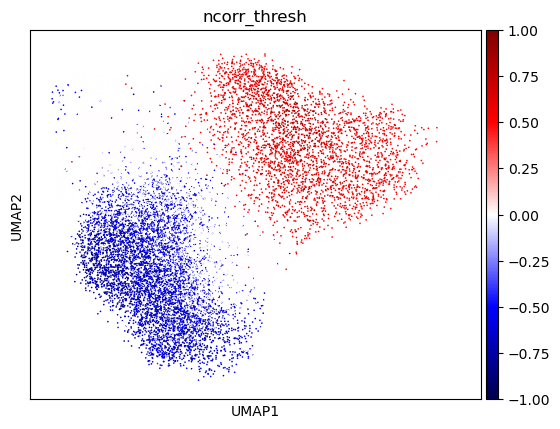

In [216]:
sc.pl.umap(Ddense, color='ncorr_thresh', cmap='seismic', vmin=-1, vmax=1)

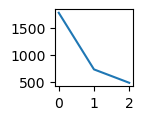

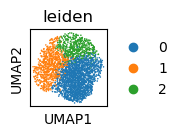

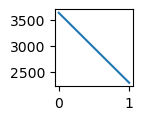

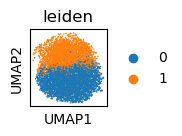

In [217]:
sig_pos = Ddense[Ddense.obs.ncorr_thresh > 0].copy()
sig_neg = Ddense[Ddense.obs.ncorr_thresh < 0].copy()
for label, d_sig, r in [('pos', sig_pos, 0.4), ('neg', sig_neg, 0.5)]:
    np.random.seed(0)
    sc.pp.neighbors(d_sig, use_rep='X')
    sc.tl.umap(d_sig)
    sc.tl.leiden(d_sig, resolution=r, key_added='leiden', seed=0)
    plt.figure(figsize=(1,1)); plt.plot(d_sig.obs.leiden.value_counts()); plt.show()
    plt.figure(figsize=(1,1)); sc.pl.umap(d_sig, color='leiden', s=5, ax=plt.gca())
    Ddense.obs[label+'_leiden'] = d_sig.obs.leiden

# count number of patches of each type per sample
Ddense.samplem['npatches'] = Ddense.obs.sid.value_counts()
Ddense.samplem[['nneg', 'npos']] = pd.crosstab(Ddense.obs.sid, Ddense.obs.ncorr_thresh.map(
                                    lambda x: 0 if x < 0 else (1 if x > 0 else np.nan)
                                ))
Ddense.samplem.drop(columns=[c for c in Ddense.samplem.columns if c.startswith('pos') or c.startswith('neg')], inplace=True)
Ddense.samplem[[f'pos{c}' for c in Ddense.obs.pos_leiden.unique() if c == c]] = pd.crosstab(Ddense.obs.sid, Ddense.obs.pos_leiden)
Ddense.samplem[[f'neg{c}' for c in Ddense.obs.neg_leiden.unique() if c == c]] = pd.crosstab(Ddense.obs.sid, Ddense.obs.neg_leiden)
Ddense.samplem = Ddense.samplem.fillna(0).drop(columns=['case'])

Ddense.write(f'_results/{name}-vae.h5ad')

## CNA of positively associated patches

In [226]:
d_sig = md.MultiAnnData(sig_pos.copy()); d_sig.sampleid = 'sid'
d_sig.samplem = d_sig.samplem.loc[d_sig.samplem.index.isin(d_sig.obs.sid.unique())]
cna.tl.nam(d_sig, force_recompute=True)
pheno = ((d_sig.samplem.TNFprior == 'y') & (d_sig.samplem.TNFprior == 'y')).astype('float')
pheno[d_sig.samplem.Status != 'UC'] = np.nan
res = cna.tl.association(d_sig, pheno, donorids=d_sig.samplem.donor, Nnull=100000)
print(res.p, res.k)

thresh = res.fdrs[res.fdrs.fdr <= 0.1].iloc[0].threshold
d_sig.obs['ncorr'] = res.ncorrs
d_sig.obs['ncorr_thresh'] = res.ncorrs * (np.abs(res.ncorrs) > thresh)
print((d_sig.obs.ncorr_thresh != 0).sum(), 'FDR10% significant patches out of', len(d_sig))

0.0013799862001379986 3
1189 FDR10% significant patches out of 2994


In [227]:
d_sig.samplem['tnf_npatches'] = d_sig.obs.sid.value_counts()
d_sig.samplem[['tnf_nneg', 'tnf_npos']] = pd.crosstab(d_sig.obs.sid, d_sig.obs.ncorr_thresh.map(
                                    lambda x: 0 if x < 0 else (1 if x > 0 else np.nan)
                                ))
d_sig.write(f'_results/{name}-vae-tnf.h5ad')